# Statistics of studied projects

In [1]:
import json
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
TOTAL_TESTS = 0
DISCREPANT_TESTS = 0
DISCREPANT_METHODS = []
METHODS_COUNT = {}
TEST_METHOD_MAP = {}
DISCREPANT_TEST_METHOD_MAP = {}

projects = ['alpakka', 'attachmentplugin', 'durabletask', 'identityazuretable', 'insights', 'ironpigeon',  'orleans_azure', 'orleans_aws', 'servicestack_dynamo', 'servicestack_s3', 'sleet_azure', 'sleet_s3', 'streamstone']

*Parse the traffic of all projects in order to extract the total unique APIs and selected tests*

In [3]:
# Collect all data from .json file, output METHODS_COUNT, TEST_METHOD_MAP, DISCREPANT_TEST_METHOD_MAP. 

def get_methods_from_file(file_path):
    
    with open(file_path, "r") as f:
        methods = f.read().splitlines()

    return methods



def find_tests_with_methods(methods_json_path, methods, output):

    global DISCREPANT_TESTS
    global TOTAL_TESTS
    global METHODS_COUNT
    global TEST_METHOD_MAP
    global DISCREPANT_METHODS
    
    with open(methods_json_path, "r") as f:
        json_data = json.load(f)

    tests = json_data.keys()

    app_tests = 0
    for i in tests:
        if not json_data[i] == []: # remove tests with no cloud methods
            app_tests += 1

    tests_with_methods = []
    test_methods_count = {}
    discrepant_methods = []
    test_methods_map = {}
    for key, value in json_data.items():
        for i in value:
            if i == 'CreateQueue' or i == 'GetQueueUrl': #Skip SQS
                continue
            if i in test_methods_count:
                test_methods_count[i] += 1
            else:
                test_methods_count[i] = 1
        for method in methods:
            if method in value:
                if not method in discrepant_methods:
                    discrepant_methods.append(method)
                if not key in tests_with_methods:
                    tests_with_methods.append(key)

                if not method in DISCREPANT_METHODS:
                    DISCREPANT_METHODS.append(method)
                
                if not key in TEST_METHOD_MAP:
                    TEST_METHOD_MAP[key] = [method]
                else:
                    TEST_METHOD_MAP[key].append(method)

                if not key in test_methods_map:
                    test_methods_map[key] = [method]
                else:
                    test_methods_map[key].append(method)

    for i in test_methods_count:
        
        if i in METHODS_COUNT:
            METHODS_COUNT[i] += test_methods_count[i]
        else:
            METHODS_COUNT[i] = test_methods_count[i]

    # Remove the hard coded place holder
    if 'orleans_aws' in methods_json_path:
        test_methods_count.pop("This_test_breaks_socket_limits", None)

    if output:
        print(f'Unique APIs: {len(test_methods_count)}')
        print(f'Total tests: {app_tests}\n')

    DISCREPANT_TESTS += len(tests_with_methods)
    TOTAL_TESTS += app_tests
    test_methods_count = {k: v for k, v in test_methods_count.items() if k in DISCREPANT_METHODS}
    test_methods_count = {k: v for k, v in sorted(test_methods_count.items(), key=lambda item: item[1], reverse=True)}
    for i in test_methods_count.keys():
        if i in DISCREPANT_METHODS:
            for j in test_methods_map.keys():
                if i in test_methods_map[j]:
                    test_methods_map[j].pop(test_methods_map[j].index(i))
    return tests, tests_with_methods


def sum_methods_if_test_exists(traffic_json_path, discrepant_test_names):
  
    with open(traffic_json_path, "r") as f:
        traffic_data = json.load(f)

    cost = {
        "PUT": 0,
        "GET": 0,
        "POST": 0,
        "DELETE": 0,
        "PATCH": 0,
        "HEAD": 0,
        "OTHER": 0
    }

    for key, value in traffic_data.items():
        
        # run on cloud if discrepant test
        if key in discrepant_test_names:
            for request in cost:
                for key in value.keys():
                    cost[request] += value[key][request]

    return cost


def parse_all_projects(output=False):

    global DISCREPANT_TESTS
    global TOTAL_TESTS

    methods_file_path = "discrepantApisEmulator.txt"
    methods = get_methods_from_file(methods_file_path)
    
    for j in projects:

        methods_json_path = f"application_sdk_methods/{j}.json"
        if output:
            print(f'Project: {j}')
        total_tests, discrepant_tests = find_tests_with_methods(methods_json_path, methods, output)
        DISCREPANT_TEST_METHOD_MAP[j] = discrepant_tests


parse_all_projects(True)

Project: alpakka
Unique APIs: 6
Total tests: 9

Project: attachmentplugin
Unique APIs: 7
Total tests: 23

Project: durabletask
Unique APIs: 30
Total tests: 101

Project: identityazuretable
Unique APIs: 6
Total tests: 51

Project: insights
Unique APIs: 20
Total tests: 171

Project: ironpigeon
Unique APIs: 8
Total tests: 7

Project: orleans_azure
Unique APIs: 23
Total tests: 189

Project: orleans_aws
Unique APIs: 12
Total tests: 58

Project: servicestack_dynamo
Unique APIs: 12
Total tests: 174

Project: servicestack_s3
Unique APIs: 3
Total tests: 13

Project: sleet_azure
Unique APIs: 12
Total tests: 11

Project: sleet_s3
Unique APIs: 9
Total tests: 11

Project: streamstone
Unique APIs: 7
Total tests: 75



# Plot APIs frequency sorted by popularity

In [4]:
TOTAL_TESTS = 0
DISCREPANT_TESTS = 0
DISCREPANT_METHODS = []
METHODS_COUNT = {}
TEST_METHOD_MAP = {}
DISCREPANT_TEST_METHOD_MAP = {}

projects = ['alpakka','orleans_azure','identityazuretable','ironpigeon','sleet','attachmentplugin', 'insights', 'durabletask', 'streamstone']
parse_all_projects()

In [5]:
# Print discrepant tests for each project
DISCREPANT_TEST_METHOD_MAP
print('Discrepant results count for each project:\n')
for k in DISCREPANT_TEST_METHOD_MAP.keys():
    print(f'{k}: {len(DISCREPANT_TEST_METHOD_MAP[k])}')

Discrepant results count for each project:

alpakka: 9
orleans_azure: 82
identityazuretable: 0
ironpigeon: 7
sleet: 11
attachmentplugin: 23
insights: 171
durabletask: 101
streamstone: 75


In [6]:
METHODS_COUNT = {k: v for k, v in sorted(METHODS_COUNT.items(), key=lambda item: item[1], reverse=True)}
while len(METHODS_COUNT) < 105:
    METHODS_COUNT[f'place_holder_{len(METHODS_COUNT)}'] = 0
df_pop = pd.DataFrame({
    'API': METHODS_COUNT.keys(),
    'Popularity': METHODS_COUNT.values(),
})

# Discrepant APIs sorted by popularity
discrepand_method_sorted = []
for method in METHODS_COUNT:
    if method in DISCREPANT_METHODS:
        discrepand_method_sorted.append((method, METHODS_COUNT[method]))

/tmp/ipykernel_8637/2025995005.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pop_plt = sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color)


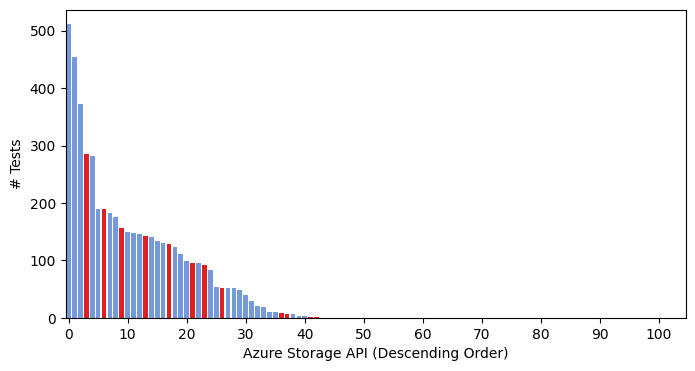

In [7]:
# color array for bar graph
bar_color = ['red' if x in DISCREPANT_METHODS else 'cornflowerblue' for x in METHODS_COUNT]
colors = {'Discrepant API':'red', 'Non-discrepant API':'deepskyblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]


pop_plt = sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color)
pop_plt.set_xlabel("Azure Storage API (Descending Order)")
pop_plt.set_ylabel("# Tests")
pop_plt.set_xticks(range(0, len(df_pop), 10))
pop_plt.figure.set_size_inches(8, 4)
# plt.rcParams.update({'font.size': 18, 'font.family': "Times New Roman"})

In [8]:
pop_plt.figure.savefig("azure_api_tests.pdf", format='pdf', bbox_inches = "tight")

# Fixing discrepant APIs and their impact on discrepant tests and results

In [9]:
# Rerun data collection for the top five projects in evaluation
TOTAL_TESTS = 0
DISCREPANT_TESTS = 0
DISCREPANT_METHODS = []
METHODS_COUNT = {}
TEST_METHOD_MAP = {}
DISCREPANT_TEST_METHOD_MAP = {}
projects = ['alpakka','orleans_azure', 'durabletask', 'streamstone']
parse_all_projects()

*How does the discrepant tests and results change if we assume that the top 5 most popular discrepant APIs are fixed?*

In [10]:
# Extract fixed tests after fixing the top 5 discrepant APIs
fix_count = {k: v for k, v in METHODS_COUNT.items() if k in DISCREPANT_METHODS}
fix_count = {k: v for k, v in sorted(fix_count.items(), key=lambda item: item[1], reverse=True)}
fix_count_test_map = TEST_METHOD_MAP.copy()
temp_dict = {}
for test in fix_count_test_map.keys():
    for method in fix_count_test_map[test]:
        if method in DISCREPANT_METHODS:
            temp_dict[test] = fix_count_test_map[test].copy()
            continue
fix_count_test_map = temp_dict


fixed_tests = set() # Store fixed_test.
counter = 0
for i in fix_count.keys():
    if i in DISCREPANT_METHODS:
        for j in fix_count_test_map.keys():
            while i in fix_count_test_map[j]:
                fix_count_test_map[j].pop(fix_count_test_map[j].index(i))
            if counter <= 5 and fix_count_test_map[j] == []:
                fixed_tests.add(j)
    counter += 1
    if counter == 5: # break after 5 fixes
        break


*Discrepant tests after Top 5 discrepant APIs fix*

In [11]:
print(f"Discrepant tests count after top 5 fixed: {len(fixed_tests)}")
print(f"Total discrepant tests count for Azure apps with discrepant results (Table V): {len(TEST_METHOD_MAP)}")

Discrepant tests count after top 5 fixed: 168
Total discrepant tests count for Azure apps with discrepant results (Table V): 267


*Actual discrepant results*

In [12]:
# Load discrepant results (Azure only)
discrepant_result_dict = json.load(open("discrepant_result_testnames.json", "r"))
print("Discrepant results count:\n")
for k in discrepant_result_dict.keys():
    print(f"{k}: {len(discrepant_result_dict[k])}")

Discrepant results count:

durabletask: 79
alpakka: 9
streamstone: 1


*Discrepant results after Top 5 discrepant APIs fix*

In [13]:
# Find fixed discrepant results by intersection
fix_discrepant_result = {}
for k in discrepant_result_dict.keys():
    fix_discrepant_result[k] = []
    for test in discrepant_result_dict[k]:
        if test in fixed_tests:
            fix_discrepant_result[k].append(test)
print("Fixed discrepant results count: \n")

for k in fix_discrepant_result.keys():
    print(f"{k}: {len(fix_discrepant_result[k])}")

Fixed discrepant results count: 

durabletask: 0
alpakka: 8
streamstone: 1


In [14]:
# Get total number of fixed discrepant results
fixed = 0
for k in fix_discrepant_result.keys():
    fixed += len(fix_discrepant_result[k])
print(f'Total fixed discrepant results count: {fixed}')

Total fixed discrepant results count: 9


## Fixing two more discrepant APIs and observing its impact

In [15]:
TOTAL_TESTS = 0
DISCREPANT_TESTS = 0
DISCREPANT_METHODS = []
METHODS_COUNT = {}
TEST_METHOD_MAP = {}
DISCREPANT_TEST_METHOD_MAP = {}
parse_all_projects()

In [16]:
# Extract fixed tests after fixing the top5 discrepant APIs
fix_count = {k: v for k, v in METHODS_COUNT.items() if k in DISCREPANT_METHODS}
fix_count = {k: v for k, v in sorted(fix_count.items(), key=lambda item: item[1], reverse=True)}
fix_count_test_map = TEST_METHOD_MAP.copy()
temp_dict = {}
for test in fix_count_test_map.keys():
    for method in fix_count_test_map[test]:
        if method in DISCREPANT_METHODS:
            temp_dict[test] = fix_count_test_map[test].copy()
            continue
fix_count_test_map = temp_dict


fixed_tests = set() # Store fixed_test.
counter = 0
for i in fix_count.keys():
    if i in DISCREPANT_METHODS:
        for j in fix_count_test_map.keys():
            while i in fix_count_test_map[j]:
                fix_count_test_map[j].pop(fix_count_test_map[j].index(i))
            if counter <= 7 and fix_count_test_map[j] == []:
                fixed_tests.add(j)
    counter += 1
    if counter == 7: #break after 5 fixes
        break


In [17]:
# Find fixed discrepant results by intersection
fix_discrepant_result = {}
for k in discrepant_result_dict.keys():
    fix_discrepant_result[k] = []
    for test in discrepant_result_dict[k]:
        if test in fixed_tests:
            fix_discrepant_result[k].append(test)
print("Fixed discrepant results: \n")
for k in fix_discrepant_result.keys():
    print(f"{k}: {len(fix_discrepant_result[k])}")

Fixed discrepant results: 

durabletask: 75
alpakka: 8
streamstone: 1


In [18]:

print('Fixed durabletask discrepant result count: ' + str(len(fix_discrepant_result['durabletask'])))

Fixed durabletask discrepant result count: 75
